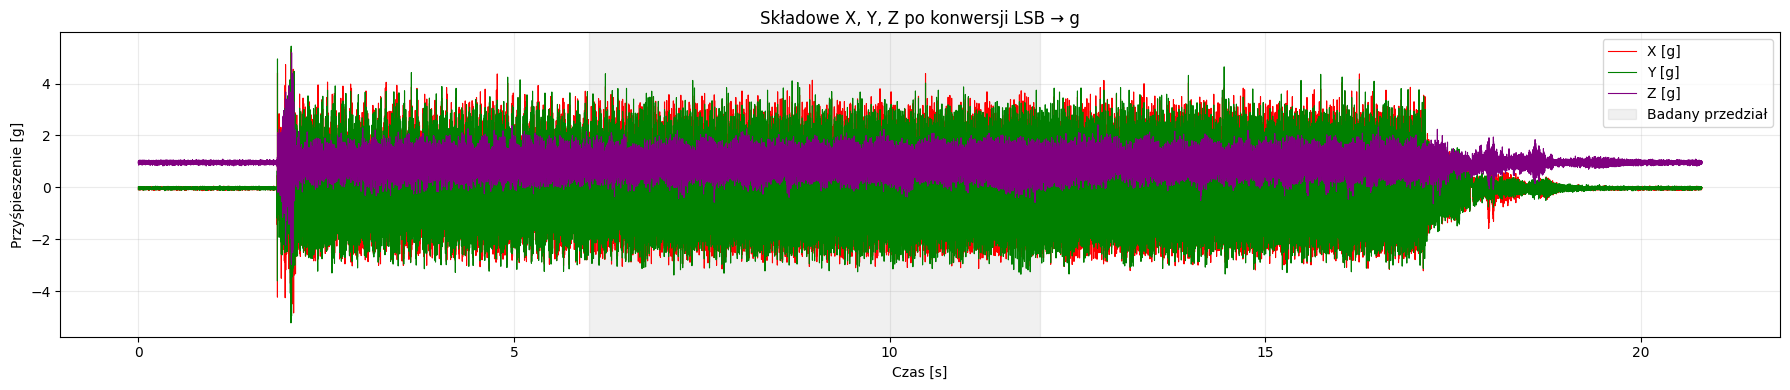

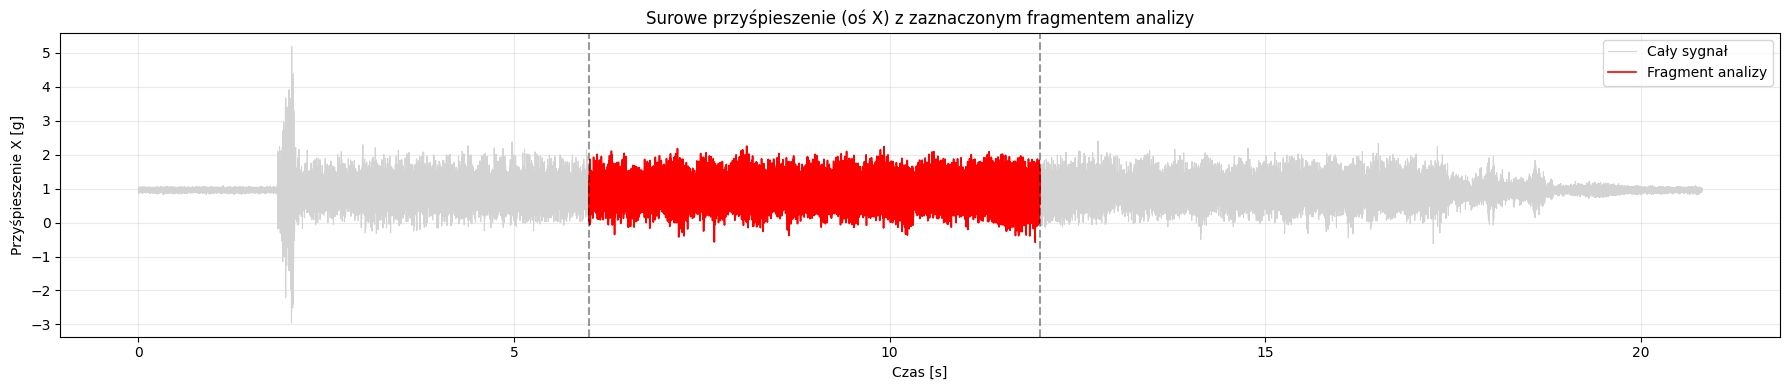

[INFO] Fragment: 6.00-12.00s -> 9601 próbek (~6.00s)


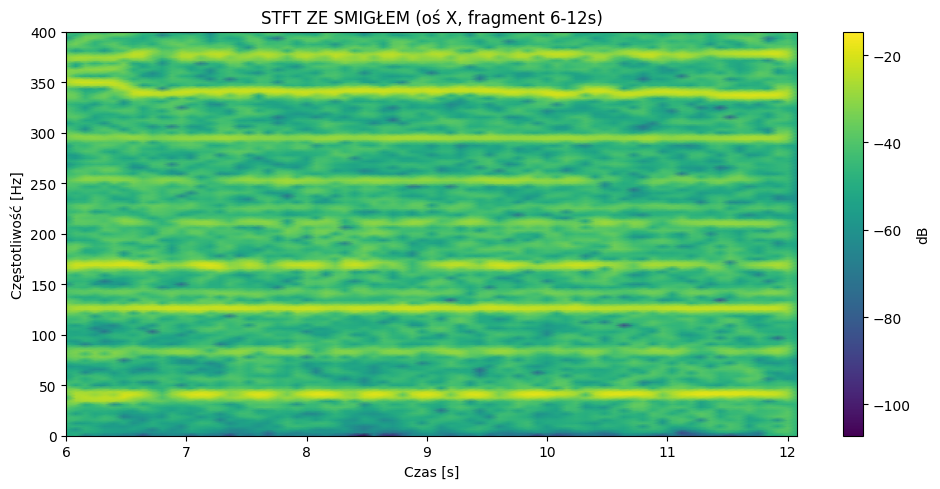

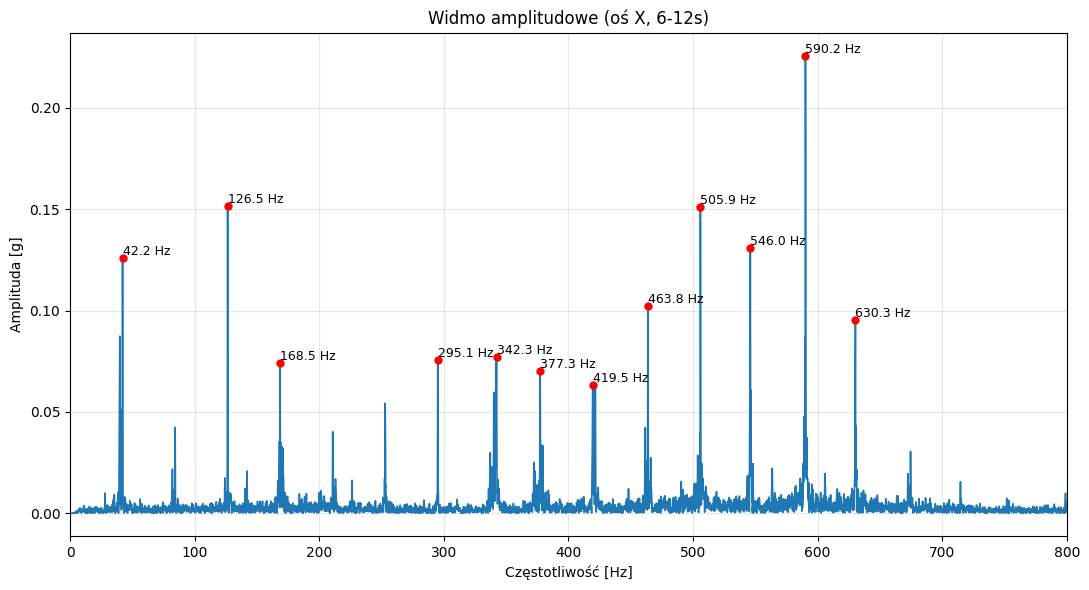


=== TOP PEAKI (częstotliwość [Hz], amplituda [g]) ===
 590.23 Hz     0.2256 g
 126.48 Hz     0.1516 g
 505.91 Hz     0.1512 g
 545.97 Hz     0.1309 g
  42.15 Hz     0.1260 g
 463.76 Hz     0.1024 g
 630.32 Hz     0.0951 g
 342.29 Hz     0.0771 g
 295.12 Hz     0.0755 g
 168.52 Hz     0.0741 g
 377.29 Hz     0.0700 g
 419.48 Hz     0.0633 g


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

fs = 1600
lsb_to_g = 0.0039
t_start, t_end = 6, 12

fmax_plot = fs/2
n_fft_pad_factor = 8
peak_prominence = 0.01
peak_distance_hz = 5.0
num_top_peaks = 12

df = pd.read_csv('data/pomiary_19_11_25/30%_z_1600Hz.csv') 
# df = pd.read_csv('data/wiertarka/01_wiertarka_3200Hz.csv')
#df = pd.read_csv('data/daneTestowe/silnik_wibracyjny_1600Hz.csv')

# --- KONWERSJA DO g ---
df['X_g'] = df['X'] * lsb_to_g
df['Y_g'] = df['Y'] * lsb_to_g
df['Z_g'] = df['Z'] * lsb_to_g

t = df['czas [s]'].to_numpy()
x_raw = df['Z_g'].to_numpy()

# --- WYKRES 1: WSZYSTKIE SKŁADOWE + PODŚWIETLENIE OKNA ANALIZY ---
plt.figure(figsize=(18,4))
plt.plot(t, df['X_g'], label='X [g]', lw=0.8, color='red')
plt.plot(t, df['Y_g'], label='Y [g]', lw=0.8, color='green')
plt.plot(t, df['Z_g'], label='Z [g]', lw=0.8, color='purple')
plt.axvspan(t_start, t_end, color='k', alpha=0.06, label='Badany przedział')
plt.title('Składowe X, Y, Z po konwersji LSB → g')
plt.xlabel('Czas [s]')
plt.ylabel('Przyśpieszenie [g]')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# --- WYKRES 2: WYBRANY SYGNAŁ (X) + ZAZNACZONE OKNO ---
mask = (t >= t_start) & (t <= t_end)
plt.figure(figsize=(18,4))
plt.plot(t, x_raw, color='lightgray', lw=0.8, label='Cały sygnał')
plt.plot(t[mask], x_raw[mask], color='red', lw=1.2, label='Fragment analizy')
plt.axvline(t_start, color='k', ls='--', alpha=0.4)
plt.axvline(t_end,   color='k', ls='--', alpha=0.4)
plt.title('Surowe przyśpieszenie (oś X) z zaznaczonym fragmentem analizy')
plt.xlabel('Czas [s]')
plt.ylabel('Przyśpieszenie X [g]')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# --- DALEJ TWÓJ DOTYCHCZASOWY PIPELINE ---
t_seg = t[mask]; x_seg = x_raw[mask]
print(f"[INFO] Fragment: {t_start:.2f}-{t_end:.2f}s -> {len(x_seg)} próbek (~{len(x_seg)/fs:.2f}s)")

# Bias + HP
N0 = int(min(len(x_seg), 2 * fs))
x0 = x_seg - np.mean(x_seg[:N0])
b, a = signal.butter(2, 5.0/(fs/2), btype='highpass')
x_hp = signal.filtfilt(b, a, x0)

# STFT
f_stft, tt_stft, Sxx = signal.stft(x_hp, fs=fs, window='hann', nperseg=512, noverlap=384)
plt.figure(figsize=(10,5))
plt.pcolormesh(tt_stft + t_start, f_stft, 20*np.log10(np.abs(Sxx)+1e-12), shading='gouraud')
plt.ylim(0, 400); plt.xlabel('Czas [s]'); plt.ylabel('Częstotliwość [Hz]')
plt.title(f'STFT ZE SMIGŁEM (oś X, fragment {t_start}-{t_end}s)')
plt.colorbar(label='dB'); plt.tight_layout(); plt.show()

# FFT z oknem + zero-padding
w = signal.windows.hann(len(x_hp), sym=False)
CG = np.sum(w)/len(w)
xw = x_hp * w
N = len(xw)
N_fft = int(2**np.ceil(np.log2(N))) * n_fft_pad_factor
X = np.fft.rfft(xw, n=N_fft)
freqs = np.fft.rfftfreq(N_fft, 1/fs)
amp = (2.0/(N*CG))*np.abs(X); amp[0] /= 2.0

# Detekcja peaków
def find_peaks_with_freqs(freqs, amp, fmax=None, prominence=0.01, distance_hz=5.0):
    mask_f = (freqs <= fmax) if fmax is not None else np.ones_like(freqs, bool)
    fc = freqs[mask_f]; ac = amp[mask_f]
    dfreq = fc[1]-fc[0]
    peaks, props = signal.find_peaks(ac, prominence=prominence, distance=max(1,int(np.round(distance_hz/dfreq))))
    return peaks, props, fc, ac

peaks, props, fc, ac = find_peaks_with_freqs(freqs, amp, fmax=fmax_plot,
                                             prominence=peak_prominence,
                                             distance_hz=peak_distance_hz)

order = np.argsort(ac[peaks])[::-1]
top_idx = peaks[order][:num_top_peaks]
top_freqs = fc[top_idx]
top_amps  = ac[top_idx]

# Wykres FFT
plt.figure(figsize=(11,6))
plt.plot(freqs, amp, lw=1.2)
plt.xlim(0, fmax_plot); plt.xlabel('Częstotliwość [Hz]'); plt.ylabel('Amplituda [g]')
plt.title(f'Widmo amplitudowe (oś X, {t_start}-{t_end}s)')

# piki
for f, a in zip(top_freqs, top_amps):
    plt.plot([f],[a],'ro', ms=5)
    plt.text(f, a, f'{f:.1f} Hz', fontsize=9, ha='left', va='bottom')

plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print("\n=== TOP PEAKI (częstotliwość [Hz], amplituda [g]) ===")
for f, a in zip(top_freqs, top_amps):
    print(f"{f:7.2f} Hz   {a:8.4f} g")


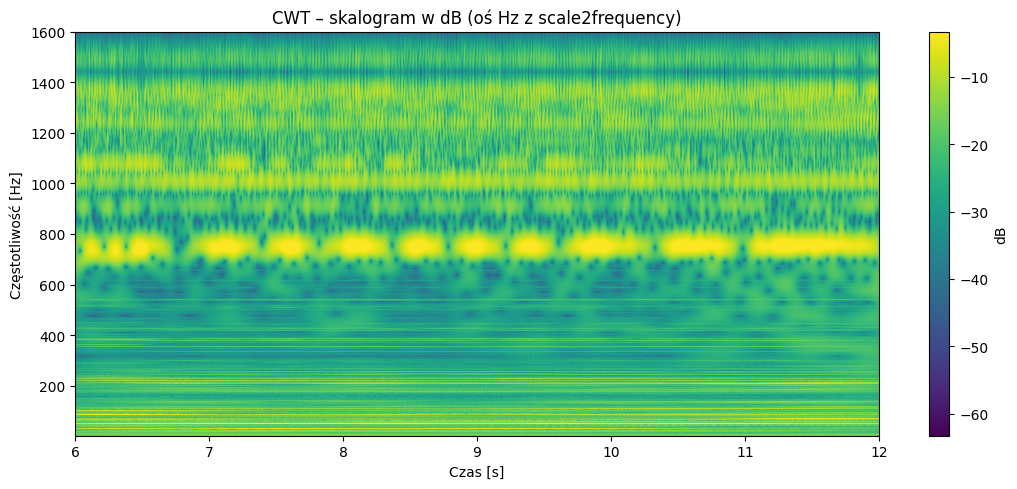

Kontrola: central_frequency = 1.0


In [35]:
import pywt

wavelet = pywt.ContinuousWavelet('cmor3.0-1.0')   # przykład; możesz podmieniać

num_scales = 800
scales = np.geomspace(1, 1e3, num_scales)  # skale w dowolnym wygodnym zakresie

coef, _ = pywt.cwt(x_hp, scales, wavelet, sampling_period=1/fs, method='fft')

freqs_from_scales = pywt.scale2frequency(wavelet, scales) / (1/fs)  # [Hz]

power_db = 20*np.log10(np.abs(coef) + 1e-12)
vmax = np.percentile(power_db, 99); vmin = vmax - 60

plt.figure(figsize=(11,5))
power_db_plot = power_db[::-1, :]
fmin = freqs_from_scales.min(); fmax = freqs_from_scales.max()
plt.imshow(power_db_plot, extent=[t_start, t_end, fmin, fmax],
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
plt.xlabel('Czas [s]'); plt.ylabel('Częstotliwość [Hz]')
plt.title('CWT – skalogram w dB (oś Hz z scale2frequency)')
plt.colorbar(label='dB')
plt.tight_layout(); plt.show()

print('Kontrola: central_frequency =', pywt.central_frequency(wavelet))
